In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [2]:
import re
import sqlite3
import pandas as pd
import math
import numpy as np

In [3]:
import geopy.distance
from bokeh.plotting import figure, output_file, show
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource
from pyproj import Proj, transform

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

# Pick an easy river

For starters I'm going to look at a single river at a time, and I'll start with an easy one. I expect a river will be easy to predict if:
 - it has a small catchment area. So the nearest rainfall station is pretty much represntative of all the rain that falls in the catchment
 - it has a small volume. So the river level will go up and down quickly in response to rainfall. 

Unfortunatly I don't (currently) have data about catchment size, and river volume, but I can take a guess  based off my own background knnowledge of the region. I would guess that maybe the Kangaroo river would be a good example for this, but lets have a look at its properties to check.

In [ ]:
con = sqlite3.connect('./Data/mydb.db')
df_stations = pd.read_sql('SELECT * FROM Stations', con)
df_gauges = pd.read_sql('SELECT * FROM Gauges', con)
df_rainfall = pd.read_sql('SELECT * FROM Rainfall', con, index_col=['station_id', 'date'])
df_levels = pd.read_sql('SELECT * FROM Levels', con, index_col=['gauge_id', 'date'])

Allen river (barrington tops), Williams river (barrington tops), Bielsdown

In [11]:
df_gauges[df_gauges['name'].str.contains('Kangaroo')]

,id,name,lat,long,elev,NearestStat


In [12]:
df_gauges[df_gauges.id==215220]

,id,name,lat,long,elev,NearestStat


## Fetch raw data - hourly

hmmm, I seem to be missing data for the kangaroo river... I wonder why. For now I'll manually fetch the csv (from https://realtimedata.waternsw.com.au/) and I'll look into this problem later. 

In [13]:
df_levels = pd.read_csv('./Data/riverlevels/215220.csv')
df_levels = df_levels[['Time', '215220', 'Unnamed: 6']]
df_levels.columns = ['datetime', 'level', 'quality']
df_levels = df_levels.iloc[3:]
df_levels = df_levels.dropna()
df_levels['datetime'] = pd.to_datetime(df_levels['datetime'])
df_levels = df_levels.set_index('datetime')
df_levels['level'] = pd.to_numeric(df_levels['level'])

/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


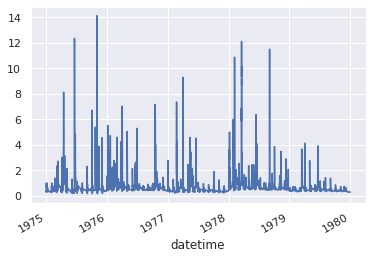

In [14]:
df_levels.loc['1975-01-01':'1980-01-01', 'level'].plot()

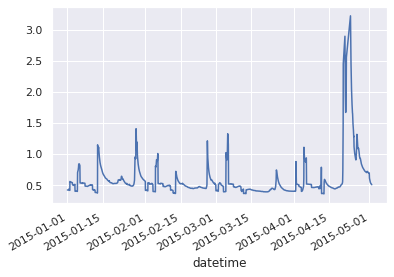

In [15]:
df_levels.loc['2015-01-01':'2015-05-01', 'level'].plot()

The kangaroo goes up and down a loooot! Much more than I would expect other rivers. Maybe the interesting points of this are around rainfall events, rather than around rising above minimum. 

## Rainfall

We have a lot of rainfall to stations to choose from. We want one which will tell us how much water is going into the kangaroo river. Lets see how well we can do by just looking at the nearest rainfall station.

Get the lat lon of the gauge at kangaroo. It's in the metadata in the river levels file which is culled on clean up. 

In [16]:
metadata = pd.read_csv('./Data/riverlevels/215220.csv', low_memory=False)['Unnamed: 7'][4]
display(metadata)

lat_lon_regex = '.* Lat:(?P<lat>[0-9\.-]*) Long:(?P<lon>[0-9\.-]*) .*'
lat_lon_regex_result = re.search(lat_lon_regex, metadata)
lat = float(lat_lon_regex_result.group('lat'))
lon = float(lat_lon_regex_result.group('lon'))
lat, lon

'215220 - KANGAROO RIVER AT HAMPDEN BRIDGE Lat:-34.72798991 Long:150.52244073 Elev:70m'

(-34.72798991, 150.52244073)

For each rainfall station, calculate its distance from our gauge. Pick the nearest.

In [17]:
def add_distances(lat, lon, df_stations):
    df_stations['dist'] = df_stations.apply(lambda x: geopy.distance.geodesic((lat, lon), (x.lat, x.long)).km, axis=1)
    return df_stations

def get_id_nth_nearest_station(lat, lon, df_stations, n):
    df_stations = add_distances(lat, lon, df_stations)
    return df_stations.sort_values('dist').iloc[n].id

nearest_station_id = get_id_nth_nearest_station(lat, lon, df_stations, 0)
df_stations[df_stations.id == nearest_station_id]

,id,name,opened_year,closed,lat,long,elev,state,dist
361,68136,BOMADERRY,1903,None,-34.85,150.62,8,NSW,16.215134


Now lets have a quick look at the how well the rainfall seems to match up with the river levels. We would expect to see every spike in river levels associated with a spike in rainfall. 

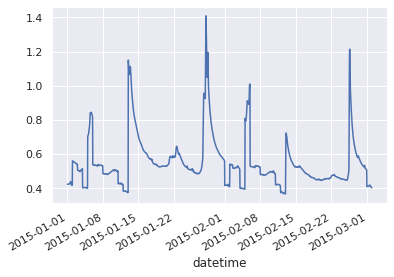

In [18]:
date_range = ('2015-01-01', '2015-03-01')
df_levels.loc[date_range[0]:date_range[1], 'level'].plot()

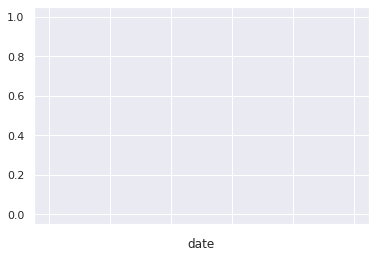

In [19]:
rainfall_kang = df_rainfall.loc[nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

Oh dear... this rainfall station has no data for this date range. That isn't going to be very useful. How about we try the next closest rainfall station. 

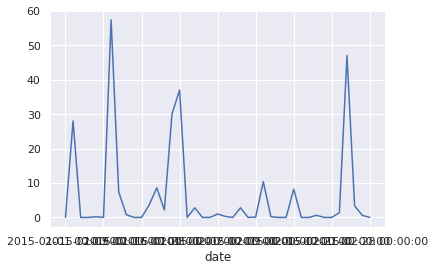

In [20]:
next_nearest_station_id = get_id_nth_nearest_station(lat, lon, df_stations, 1)
rainfall_kang = df_rainfall.loc[next_nearest_station_id]
rainfall_kang.loc[date_range[0]:date_range[1], 'rainfall'].plot()

This seems pretty good... Where is it though?

## Find a good gauge

Where are all our stations? Lets plot the nearby rainfall stations on a map to see what our cmhoices are...

In [21]:
def lon_lat_to_wm(lon, lat):
    wm_x, wm_y = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, lat)  # longitude first, latitude second.
    return wm_x, wm_y

In [22]:
station_distances = add_distances(lat, lon, df_stations)
station_distances['wm_x'] = station_distances.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[0], axis=1)
station_distances['wm_y'] = station_distances.apply(lambda x: lon_lat_to_wm(x.long, x.lat)[1], axis=1)
station_distances

,id,name,opened_year,closed,lat,long,elev,state,dist,wm_x,wm_y
0,46024,WILCANNIA (MURTEE),1923,None,-31.58,143.49,60,NSW,742.900632,1.597323e+07,-3.708304e+06
1,47019,MENINDEE POST OFFICE,1876,None,-32.39,142.42,61,NSW,795.526485,1.585412e+07,-3.814614e+06
2,47051,TANGRAMBALLY,1952,None,-34.50,143.67,-9999,NSW,628.856981,1.599327e+07,-4.096139e+06
3,47100,WENTWORTH LOCK 10 (MURRAY RIVER),1872,None,-34.11,141.90,-9999,NSW,795.361253,1.579624e+07,-4.043582e+06
4,48009,CARINDA (BOOROOMA),1881,None,-30.10,147.46,122,NSW,588.449269,1.641517e+07,-3.516410e+06
...,...,...,...,...,...,...,...,...,...,...,...
499,75128,WHEALBAH,1900,None,-33.72,145.30,-9999,NSW,493.957843,1.617472e+07,-3.991267e+06
500,75137,HAY (PEVENSEY),1967,None,-34.56,144.64,85,NSW,539.557507,1.610125e+07,-4.104247e+06
501,75157,THE CUBAS,1887,None,-33.87,144.88,94,NSW,528.012406,1.612797e+07,-4.011360e+06
502,75163,HILLSTON ( ALDINGA),1971,None,-33.35,145.87,135,NSW,455.941177,1.623817e+07,-3.941853e+06


In [ ]:
output_file("tile.html")
tile_provider = get_provider(CARTODBPOSITRON)

# define our points in web mercator
wm_x, wm_y = lon_lat_to_wm(lon, lat)
rainfall_station_location = ColumnDataSource(station_distances)

# define the hover information
tooltips = [
    ('Name', '@name'),
    ('Distance from gauge', '@d_kang')
]

# range bounds supplied in web mercator coordinates
plot_size = 100000
x_range = (wm_x-plot_size/2, wm_x+plot_size/2)
y_range = (wm_y-plot_size/2, wm_y+plot_size/2)

# make the plot
p = figure(x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator", tooltips=tooltips)
p.add_tile(tile_provider)
p.circle(x=[wm_x], y=[wm_y], size=10, fill_color="red")
p.circle(x="wm_x", y="wm_y", size=15, fill_color="blue", fill_alpha=0.8, source=rainfall_station_location)

show(p)

OK, so none of the stations are particularly close, and none are on the plateu. So now we're choosing betweeen bad options. 

## Choose station based off correlation

To choose between the nearby stations, lets look at how well the rainfall levels correlate with the river level. I expect that the relationship will between rainfall and river level will be highly non-linear and incorporate some time delay.

In [23]:
df_levels_max_daily = df_levels.groupby(df_levels.index.date).max()
df_levels_max_daily.index = pd.to_datetime(df_levels_max_daily.index)

Match each river level with the rainfall of the previous day - at a particular gauge

In [24]:
def get_rainfall_at_station(df_rainfall, station_id):
    rainfall_at_nearest = df_rainfall.loc[station_id]
    rainfall_at_nearest.index = pd.to_datetime(rainfall_at_nearest.index)
    return rainfall_at_nearest

In [25]:
df_kang = df_levels_max_daily
nearest_station_ids = [get_id_nth_nearest_station(lat, lon, df_stations, i) for i in range(10)]
nearest_station_ids.append(get_id_nth_nearest_station(lat, lon, df_stations, -1))
for nth_nearest_station_id in nearest_station_ids:
    rainfall_at_nearest = get_rainfall_at_station(df_rainfall, nth_nearest_station_id)

    df_kang = pd.merge(df_kang, rainfall_at_nearest['rainfall'], left_index=True, right_index=True, how='left')
    df_kang = df_kang.rename(columns={'rainfall': nth_nearest_station_id})
df_kang.head(10)

,level,68136,68003,68031,68168,68076,68154,70078,68166,70039,69049,48178
1973-01-12,0.837,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1973-02-12,0.747,NaN,9.9,NaN,8.6,3.3,NaN,NaN,2.8,4.6,4.8,NaN
1973-03-12,0.746,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1973-04-12,0.688,NaN,3.6,NaN,0.0,3.0,NaN,NaN,1.0,3.8,0.8,NaN
1973-05-12,0.861,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN
1973-06-11,0.525,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,5.1,0.3,NaN
1973-06-12,0.738,NaN,22.4,NaN,16.3,19.8,NaN,NaN,8.4,19.1,10.7,NaN
1973-07-11,0.915,NaN,13.0,NaN,11.4,1.5,NaN,NaN,5.1,2.0,0.8,NaN
1973-07-12,0.642,NaN,0.0,NaN,0.8,0.0,NaN,NaN,0.0,0.0,0.3,NaN
1973-08-11,0.676,NaN,21.6,NaN,12.2,16.8,NaN,NaN,0.0,11.7,11.9,NaN


I think this'll be a good format to work with for checking which rainfall stations is best to use for this gauge. The index is the timestamp, so we're matching up observations with time. The river level has been selected for the max river level which occured that day since we had hourly data. Then for each of the rainfall stations of interest (close stations chosen here), we have a column of rainfall recorded at that station on that day.  

In [26]:
def plot_correlation_at_lags(df, station_id, max_lag):
    c = [df_kang['level'].corr(df_kang[station_id].shift(i), method='spearman') for i in range(max_lag)]

    if not any([math.isnan(v) for v in c]):
        plt.plot(range(max_lag), c)

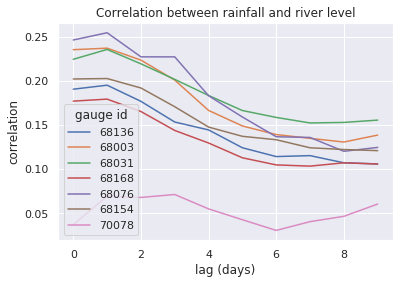

In [27]:
for nth_nearest_station_id in nearest_station_ids:
    plot_correlation_at_lags(df_kang, nth_nearest_station_id, 10)
plt.title("Correlation between rainfall and river level")
plt.xlabel("lag (days)")
plt.ylabel("correlation")
plt.legend(nearest_station_ids, title='gauge id')
plt.show()

Here we use the Spearman's rank correlation, as opposed to the more common Pearson's correlation. This means that we are looking at the strength of any monotonic relationship rather than a strictly linear relationship. We would expect the relationship between reainfall and river level to be monotonic (more rain always -> higher river), but not necessarily linear. 

We look at how well the rainfall correlates with the river level at different gauges, and with different amounts of lag. As we would expect for such a small volume (highly responsive) river, the best indicator of today's river level is today or yesterday's rainfall. We also note that the correlation with rainfall stations which are nearby are all high relative to the one rainfall station which was chosen to be far away. 

In this case, the nearest rainfall station is in fact the most highly correlated, however this wouldn't necessarily be true in general. 

In [28]:
STATION_ID = 68076
N_DAYS_LAG = 3

## Format dataset for training

Here we just reformat the dataframe to use the station and n_days we decided on. We'll also remove any rows which are missing data. 

In [29]:
input_data = df_kang[['level']].copy()
input_data['level1'] = df_kang['level'].shift(-1).values
input_data['level2'] = df_kang['level'].shift(-2).values
for i in range(N_DAYS_LAG+1):
    input_data[f"lag{i}"] = df_kang[STATION_ID].shift(-i).values
input_data = input_data.dropna()
input_data

,level,level1,level2,lag0,lag1,lag2,lag3
1973-01-12,0.837,0.747,0.746,0.0,3.3,0.0,3.0
1973-02-12,0.747,0.746,0.688,3.3,0.0,3.0,0.0
1973-03-12,0.746,0.688,0.861,0.0,3.0,0.0,0.0
1973-04-12,0.688,0.861,0.525,3.0,0.0,0.0,19.8
1973-05-12,0.861,0.525,0.738,0.0,0.0,19.8,1.5
...,...,...,...,...,...,...,...
2000-07-02,0.359,0.905,0.714,3.0,8.0,4.0,2.0
2000-07-03,0.905,0.714,0.573,8.0,4.0,2.0,1.0
2000-09-25,0.317,0.373,0.915,3.0,17.0,33.0,2.0
2000-11-06,0.377,0.491,0.391,1.0,5.0,3.0,2.0


Some models require categorical or binary data. This defines some transformations between categorical, binary and numerical data types for the river levels. 

By the nature of the problem (predicting whether it will be paddle-able) we have some pretty intuitive and useful cut offs. We will use "stay home", "low", "good", "high", "flood" as our categories. To convert those levels into meters we refer to the waterways guide: http://www.waterwaysguide.org.au/map?nid=6385

In [61]:
CATS = ['stay home', 'low', 'good', 'high', 'flood']
CUT_OFFS = np.array([0.75, 0.9, 1.15, 1.45, float('inf')])

num_to_cat_thresholds = list(zip(CUT_OFFS, CATS))

mid_points = (CUT_OFFS[:-2] + CUT_OFFS[1:-1]) / 2
MIN_LEVEL = 0.5  # TODO: make these mean of values in that category
MAX_LEVEL = 1.7
cat_to_num_values = {c: v for c,v in zip(CATS[1:-1], mid_points)}
cat_to_num_values.update({CATS[0]: MIN_LEVEL, CATS[-1]: MAX_LEVEL})


def num_to_cat(num):
    for cut_off, cat in num_to_cat_thresholds:
        if num<=cut_off:
            return cat
        
def cat_to_num(cat):
    return cat_to_num_values[cat]

def num_to_binary(num):
    return num>CUT_OFFS[0]

def cat_to_binary(cat):
    return cat != CATS[0]

Lets take a quick look at what our dataset looks like once we convert it to categorical. 

In [31]:
df_cat = input_data.copy()
df_cat['level'] = df_cat.apply(lambda x: num_to_cat(float(x.level)), axis=1)
pd.value_counts(df_cat['level'])

stay home    7828
flood         487
low           382
good          332
high          140
Name: level, dtype: int64

As we can see this is a highly imbalanced dataset. The vast majority of examples are "stay home", but in fact this is what we are least interested in knowing! Some models, eg. decision trees, effectively weight the importance of each class by its frequency in the dataset (it's just counting number of correct V incorrect). To mitigate this problem, we might want to subsample the "stay home" values, so that the number of examples which we use to train the tree are roughly equal across all the classes. 

In [63]:
def rebalance_stay_home(dataset):
    """
    Select the number of 'stay home' rows, to be equal to the next second common value. 
    """
    n_stay_home = sorted(dataset['level'].value_counts().values)[-2] + 1  # second largest value
    sampled_stay_home = dataset[dataset['level']=='stay home'].sample(n_stay_home)

    df_sampled = dataset[dataset['level']!="stay home"]
    df_sampled = df_sampled.append(sampled_stay_home)
    return df_sampled

df_rebalanced_cat = rebalance_stay_home(df_cat)
df_rebalanced_cat['level'].value_counts()

stay home    488
flood        487
low          382
good         332
high         140
Name: level, dtype: int64

We can do a similar rebalancing with continuous data by sampling from the original dataset, and keeping a sampled point with probability inversly proportional to its frerquency in the dataset. However I'm not sure this is really what we want. It really skews the data toward the extreme cases. Maybe what we actually want is to just flatten that peak a bit. 

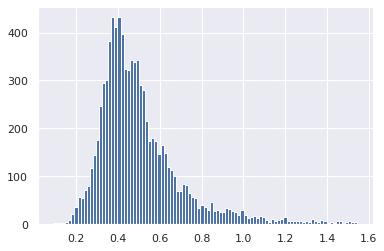

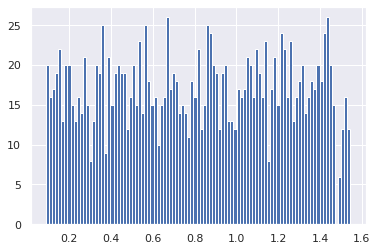

In [75]:
upper_bound = np.quantile(input_data['level'], 0.95)
X = input_data[input_data['level']<upper_bound]['level'].values.reshape(-1,1)

# make plot with histogram and kde
bins = np.linspace(np.min(X), np.max(X), 100)
densities, bins, p = plt.hist(X[:, 0], bins=bins, density=False)
plt.show()

def get_weight(sample):
    try:
        density = densities[np.max(np.argwhere(bins<sample))]
    except:
        density = 1
    return 1/density

weights = input_data.apply(lambda x: get_weight(x.level), axis=1)
weights

df_rebalanced_num = input_data.sample(n=10000, replace=True, weights=weights)
_,_,_ = plt.hist(df_rebalanced_num['level'], bins=bins, density=False)

Now we shuffle and split into test and train sets

### TODO: if in the future we're doing sampling with replacement, then we need to be careful to split into sets before sampling. Otherwise we could end up with cross contamination between sets. 

In [65]:
def split_dataset(dataset):
    randomised = dataset.sample(frac=1)
    test_20 = randomised[:len(dataset)//5]
    train_80 = randomised[len(dataset)//5:]

    all_input = randomised[['level1', 'level2', 'lag0', 'lag1', 'lag2', 'lag3']]
    all_result = randomised['level'].values
    train_input = train_80[['level1', 'level2', 'lag0', 'lag1', 'lag2', 'lag3']]
    train_result = train_80['level'].values
    test_input = test_20[['level1', 'level2', 'lag0', 'lag1', 'lag2', 'lag3']]
    test_result = test_20['level'].values
    
    return {'all': all_input, 'train': train_input, 'test': test_input}, {'all': all_result, 'train': train_result, 'test': test_result}

inputs, results = split_dataset(df_rebalanced_cat)

## Define evaluation metrics

Now we need to come up with metrics which are indicitive of desired performance.

binary metrics are used for paddleable / not paddleable. Ie. =='stay home'. This is the coarsest measure that might be useful.

In [79]:
def binary_metrics(preds, expec):  
    precision = precision_score(y_true=expec, y_pred=preds)
    recall = recall_score(y_true=expec, y_pred=preds)
    f1 = 2*precision*recall / (precision + recall)
    return precision, recall, f1

Numeric metrics such as mean squared difference, and mean absolute difference are more difficult to interpret, but are a better measure of 'closeness'.

In [67]:
def numeric_metrics(preds, expec):
    mean_sqr_diff = np.mean((np.array(preds) - np.array(expec))**2)
    mean_abs_diff = np.mean(np.abs(np.array(preds) - np.array(expec)))
    return mean_sqr_diff, mean_abs_diff

Confusion matrix tells us where we are making errors. This is just a quick viz. 

In [132]:
def plot_cmat(model, test_input, test_result):
    plot_confusion_matrix(model, test_input, test_result, labels=CATS, cmap=plt.cm.Blues, normalize='true')

This will run all the available metrics on a classifier

In [69]:
from sklearn.model_selection import cross_val_score
def all_clas_metrics(model, inputs, results):
    preds = model.predict(inputs['test'])
    expected = results['test']

    print(cross_val_score(model, inputs['all'], results['all']))
    print(binary_metrics([cat_to_binary(p) for p in preds], [cat_to_binary(e) for e in expected]))
    print(numeric_metrics([cat_to_num(p) for p in preds], [cat_to_num(e) for e in expected]))
    
    plot_cmat(model, inputs['test'], results['test'])
    plt.show()

This will run all the available metrics on a regressor

In [70]:
def all_reg_metrics(model, inputs, results):
    preds = model.predict(inputs['test'])
    expected = results['test']

    print(cross_val_score(model, inputs['all'], results['all']))
    print(binary_metrics([num_to_binary(p) for p in preds], [num_to_binary(e) for e in expected]))
    print(numeric_metrics(preds, expected))

## Make models

Lets start with the simplest stupidest models we can come up with. If our proper models are no better than these, then they are truly crap! They'll serve as a bit of benchmark for all these metrics. 

## R0

[0.26502732 0.26502732 0.26775956 0.26775956 0.26575342]
(0.0, 0.0, nan)
(0.49577054794520536, 0.5475342465753424)


/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jemma/anaconda3/envs/river_levels/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


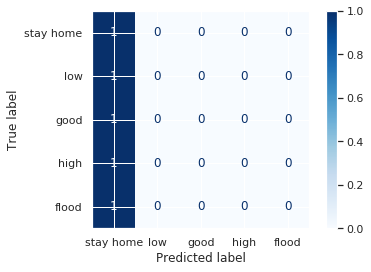

In [141]:
from sklearn.base import RegressorMixin, ClassifierMixin
from scipy.stats import mode

class NullClassifier(ClassifierMixin):
    def fit(self, X=None, y=None):
        self.y_bar_ = mode(y)[0][0]
        self.classes_ = sorted(CATS)

    def predict(self, X=None):
        return X.shape[0] * [self.y_bar_]
    
    def get_params(self, deep):
        return {}
        
# make a categorical dataset
inputs_cat, results_cat = split_dataset(df_rebalanced_cat)

# evaluate performance of classifier
null_clas = NullClassifier()
null_clas.fit(inputs_cat['train'], results_cat['train'])
all_clas_metrics(null_clas, inputs_cat, results_cat)

In [142]:
class NullRegressor(RegressorMixin):
    def fit(self, X=None, y=None):
            # If y is numerical predict mean of y
            self.y_med_ = np.median(y)
            
    def predict(self, X=None):
        return np.ones(X.shape[0]) * self.y_med_
    
    def get_params(self, deep):
        return {}

# make a numeric dataset
inputs, results = split_dataset(df_rebalanced_num.copy())

# evaluate performance of regressor
null_reg = NullRegressor()
null_reg.fit(inputs['train'], results['train'])
all_reg_metrics(null_reg, inputs, results)

[-0.09041505 -0.10999194 -0.09731132 -0.10000276 -0.10087599]
(0.924, 1.0, 0.9604989604989606)
(5.4465478505, 1.5152745)


## R1

Use a single rule to seperate the data. 

In [72]:
r1 = DecisionTreeClassifier(max_depth = 1)
r1 = r1.fit(inputs['train'], results['train'])

all_clas_metrics(r1, inputs, results)

ValueError: Unknown label type: 'continuous'

## No change

### Decision Tree(s)

I think the most promising (easy) approach will be decision tree(s) as this should work well with non-linear relationships. A decision tree almost avoids parameterising the relationship between the variables, and instead models it as highly peicewise.

The downfall of downfalll imght be that it treats every interval as independent. This means it can't extrapolate trends into regions with less data. 

Now lets train the model!

In [ ]:
dt = DecisionTreeClassifier(max_features='auto')
rf = RandomForestClassifier(max_features='auto')

dt = dt.fit(inputs['train'], results['train'])
rf = rf.fit(inputs['train'], results['train'])

That was easy. Now evaluate it. 

In [ ]:
print("decision tree metrics") 
all_clas_metrics(dt, inputs, results)
    
print("random forrest metrics") 
all_clas_metrics(rf, inputs, results)

### Mulit linear regression

Maybe first look at rainfall V river level plot. If its highly non-linear this isn't going to work. Try to make it linear. 